<a href="https://colab.research.google.com/github/mohanrajmit/MLDS2020/blob/master/Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Preparation

In [0]:
!git clone https://github.com/mohanrajmit/IDD.git

Cloning into 'IDD'...
remote: Enumerating objects: 4864, done.
remote: Counting objects: 100% (4864/4864), done.
remote: Compressing objects: 100% (4476/4476), done.
remote: Total 4864 (delta 209), reused 4767 (delta 125), pack-reused 0
Receiving objects: 100% (4864/4864), 28.31 MiB | 39.23 MiB/s, done.
Resolving deltas: 100% (209/209), done.


In [0]:
import cv2
from imutils import paths

In [0]:
labels_path = paths.list_images("/content/IDD/idd20k_lite/gtFine")
labels_path = sorted(labels_path)


In [0]:
def binarylab(labels_name):
  #counter=0
  #print(labels_name.shape)
  x = np.zeros([227,320,8])
  for i in range(227):
    for j in range(320):      
      if (labels_name[i][j]==255):
        #print(counter)
        x[i,j,7]=1
      else:
        x[i,j,labels_name[i][j]]=1

  return x

In [0]:
train_labels = []
val_labels = []
train_labels_conv = []
val_labels_conv = []

import numpy as np
for imagePath in labels_path:
  #print(imagePath)
  make = imagePath.split("/")[-3]
  #print(make)
  image = cv2.imread(imagePath)
  b,g,r = cv2.split(image)
  binary_label = binarylab(r)
  if make == "train":
    train_labels.append(image)
    train_labels_conv.append(binary_label)
  else:
    val_labels.append(image)
    val_labels_conv.append(binary_label)
#print(images_path[0])

In [0]:
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
train_labels_conv = np.array(train_labels_conv)
val_labels_conv = np.array(val_labels_conv)
#sample= train_laebls[0]
print(train_labels.shape)

(1403, 227, 320, 3)


In [0]:
train_labels1 = train_labels_conv.reshape(1403,72640,8)
val_labels1 = val_labels_conv.reshape(204,72640,8)

In [0]:
print(train_labels1.shape)

(1403, 72640, 8)


In [0]:
images_path=paths.list_images("/content/IDD/idd20k_lite/leftImg8bit")
images_path=sorted(images_path)

In [0]:
train_images = []
val_images = []
test_images = []
import numpy as np
for imagePath in images_path:
  #print(imagePath)
  make = imagePath.split("/")[-3]
  #print(make)
  image = cv2.imread(imagePath)
  if make == "train":
    train_images.append(image)
  elif make == "test":
    test_images.append(image)
  else:
    val_images.append(image)

In [0]:
train_images = np.array(train_images)
val_images = np.array(val_images)
test_images = np.array(test_images)

In [0]:
print(train_images.shape)
print(test_images.shape)
print(val_images.shape)

(1403, 227, 320, 3)
(404, 227, 320, 3)
(204, 227, 320, 3)


(227, 320, 3)
(227, 320, 3)


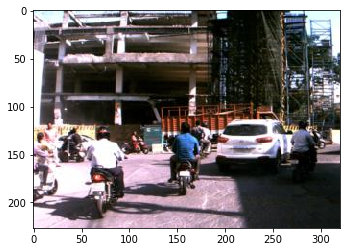

In [0]:
sample_image_label = train_labels[0]
sample_image = train_images[0]
print(sample_image_label.shape)
print(sample_image.shape)
from matplotlib import pyplot as plt
import imutils
plt.figure("original_image")
plt.imshow(imutils.opencv2matplotlib(sample_image))

In [0]:

colors = np.array([
    [128, 64, 18],      # Drivable
    [244, 35, 232],     # Non Drivable
    [220, 20, 60],      # Living Things
    [0, 0, 230],        # Vehicles
    [220, 190, 40],     # Road Side Objects
    [70, 70, 70],       # Far Objects
    [70, 130, 180],     # Sky
    [0, 0, 0]           # Misc
], dtype=np.int)

def visualize(temp, plot=True):
    r,g,b =cv2.split(temp)
    color_image = np.zeros(
        (r.shape[0], r.shape[1], 3), dtype=np.int)
    for i in range(7):
        color_image[r == i] = colors[i]

    color_image[r == 255] = colors[7]
    #plt.imshow(image_frame)
    plt.imshow(color_image)
    plt.show()

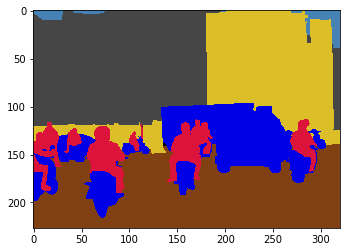

In [0]:
visualize(sample_image_label)

## Model

In [0]:
import keras.models as models
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape, Permute
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.layers import merge
from keras_radam import RAdam

In [0]:
!pip install keras-radam

In [0]:
opt = RAdam(total_steps=5000, warmup_proportion=0.1, min_lr=1e-5)

In [0]:
from keras import backend as K
K.set_image_data_format('channels_last')
from keras.layers import Lambda, Input
import tensorflow as tf

#from keras.backend import tf as ktf

Model architecture

In [0]:
def create_encoding_layers():
    kernel = 3
    filter_size = 64
    pad = 1
    pool_size = 2
    return [
        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(filter_size, kernel, kernel, border_mode='valid'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2),strides=2),

        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(128, kernel, kernel, border_mode='valid'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(pool_size, pool_size),strides=2),

        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(256, kernel, kernel, border_mode='valid'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(pool_size, pool_size),strides=2),

        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(512, kernel, kernel, border_mode='valid'),
        BatchNormalization(),
        Activation('relu'),
    ]

def create_decoding_layers():
    kernel = 3
    filter_size = 64
    pad = 1
    pool_size = 2
    return[
        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(512, kernel, kernel, border_mode='valid'),
        BatchNormalization(),

        UpSampling2D(size=(pool_size,pool_size)),
        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(256, kernel, kernel, border_mode='valid'),
        BatchNormalization(),

        UpSampling2D(size=(pool_size,pool_size)),
        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(128, kernel, kernel, border_mode='valid'),
        BatchNormalization(),

        UpSampling2D(size=(pool_size,pool_size)),
        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(filter_size, kernel, kernel, border_mode='valid'),
        BatchNormalization(),
    ]


data_shape = 227*320

segnet_basic = models.Sequential()

# Adding layers 
segnet_basic.add(Layer(input_shape=(227,320,3)))

segnet_basic.encoding_layers = create_encoding_layers()
for l in segnet_basic.encoding_layers:
    segnet_basic.add(l)

# Note: it this looks weird, that is because of adding Each Layer using that for loop
# instead of re-writting mode.add(somelayer+params) everytime.

segnet_basic.decoding_layers = create_decoding_layers()
for l in segnet_basic.decoding_layers:
    segnet_basic.add(l)

#segnet_basic.add(ZeroPadding2D(padding=(2,0)))

segnet_basic.add(Convolution2D(8, 1, 1, border_mode='valid'))
segnet_basic.add(Lambda(lambda image: tf.image.resize_images(image,(227,320))))
#segnet_basic.add(Reshape(-1,3), input_shape=(224,320,7))
#segnet_basic.add(Lambda(lambda x: x[:508480])) # throw away some, so that #data = 224^2
#segnet_basic.add(Reshape(227,320,7))

segnet_basic.add(Reshape((data_shape,8), input_shape=(227,320,8)))
#segnet_basic.add(Permute((2, 1)))
segnet_basic.add(Activation('softmax'))
segnet_basic.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="valid")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="valid")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), padding="valid")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), padding="valid")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), padding="valid")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), padding="valid")`
/usr/local/lib/pyt

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (1, 1), padding="valid")`


In [0]:
segnet_basic.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_2 (Layer)              (None, 227, 320, 3)       0         
_________________________________________________________________
zero_padding2d_9 (ZeroPaddin (None, 229, 322, 3)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 227, 320, 64)      1792      
_________________________________________________________________
batch_normalization_9 (Batch (None, 227, 320, 64)      256       
_________________________________________________________________
activation_6 (Activation)    (None, 227, 320, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 113, 160, 64)      0         
_________________________________________________________________
zero_padding2d_10 (ZeroPaddi (None, 115, 162, 64)     

Model Training

In [0]:
nb_epoch = 100
batch_size = 16

history = segnet_basic.fit(train_images, train_labels1, batch_size=batch_size,epochs=nb_epoch,verbose=1, validation_data=(val_images, val_labels1))
#segnet_basic.save_weights('model_weight_ep100.hdf5')
#score = autoencoder.evaluate(X_test, X_test, show_accuracy=True, verbose=0)
#print('Test score:', score[0])
#print('Test accuracy:', score[1])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1403 samples, validate on 204 samples
Epoch 1/100
1403/1403 [==============================] - 39s 28ms/step - loss: 1.5337 - acc: 0.5138 - val_loss: 0.9664 - val_acc: 0.6980
Epoch 2/100
1403/1403 [==============================] - 30s 22ms/step - loss: 0.7480 - acc: 0.7456 - val_loss: 0.8446 - val_acc: 0.7182
Epoch 3/100
1403/1403 [==============================] - 30s 22ms/step - loss: 0.6655 - acc: 0.7665 - val_loss: 0.8194 - val_acc: 0.7318
Epoch 4/100
1403/1403 [==============================] - 30s 22ms/step - loss: 0.6530 - acc: 0.7701 - val_loss: 1.2741 - val_acc: 0.6800
Epoch 5/100
1403/1403 [==============================] - 30s 22ms/step - loss: 0.6183 - acc: 0.7797 - val_loss: 0.7839 - val_acc: 0.7622
Epoch 6/100
1403/1403 [==============================] - 30s 22ms/step - loss: 0.5814 - acc: 0.7897 - val_loss: 0.8769 - val_acc: 0.7180
Epoch 7/100
1403/1403 [============

## Testing the trainied Model

In [0]:
test_path= paths.list_images("/content/IDD/idd20k_lite/leftImg8bit/test")
test_path=sorted(test_path)

In [0]:
test_images_final = []
test_images_name = []
import os
for imagePath in test_path:
  image=cv2.imread(imagePath)
  #print(imagePath)
  make = imagePath.split("/")[-1]
  filename = make[:make.rfind("_")]
  #print(filename)
  make1=imagePath.split("/")[-2]  
  directory="output/"+ make1
  if not os.path.exists(directory):
    os.makedirs(directory)
  image_name = "output/"+ make1+"/"+filename+"_label.png"
  test_images_final.append(image)
  test_images_name.append(image_name)


In [0]:
test_images_final = np.array(test_images_final)

## Model Prediction

In [0]:
output = segnet_basic.predict_proba(test_images_final, verbose=0)
output = output.reshape(output.shape[0],227,320,8)

In [0]:
print(output.shape)
print(output.shape[0])

(404, 227, 320, 8)
404


In [0]:
for i in range(output.shape[0]):
  #print(i)
  sample_pred = np.argmax(output[i],axis=-1)
  #print(sample_pred.shape)
  #image_name = "output/" + str(image_counter) + ".png"
  sample_pred[sample_pred == 7] = 255
  #color_image[label_map == 255] = colors[7]
  cv2.imwrite(test_images_name[i],sample_pred)

Saving the results

In [0]:
!zip -r output.zip output

Download the output

In [0]:
from google.colab import files
files.download('/content/output.zip') 

In [0]:
# !sudo apt install zip unzip